In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import pickle

# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [21]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

Load the different splits

In [22]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [23]:
split_data.keys()

dict_keys(['random', 'stratified', 'udersample', 'oversample'])

Create our initial model

In [24]:
from sklearn.neural_network import MLPClassifier

# Define the model
model = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=1000, random_state=42)

Now we will train and test our model on the 4 different training splits we have created, we can then have a look at some performance metrics and think about how we can improve our model 

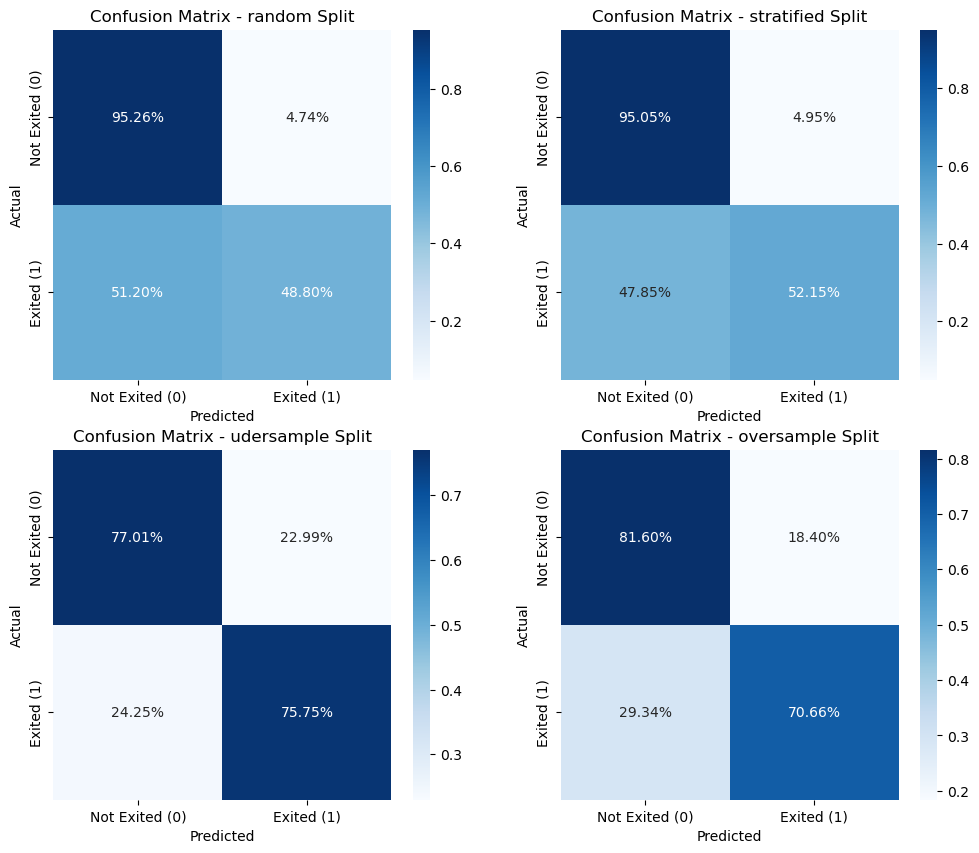

<Figure size 800x600 with 0 Axes>

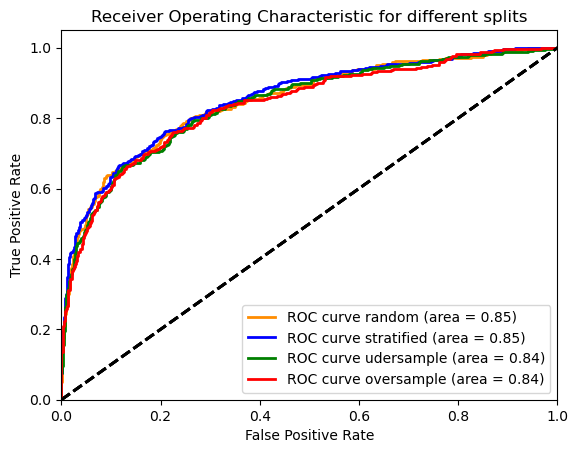

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
performance = {}
def evaluating_perfromance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):
    #Create a 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))
    plt.figure()
    colors = ['darkorange', 'blue', 'green', 'red']
    # Loop through the splits in split_data
    for i, split in enumerate(split_data):
        X_train, X_val, y_train, y_val =split_data[split]
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict probabilities for the test set
        y_score = model.predict_proba(X_val)[:, 1]

        # Predict our target variable
        y_val_pred = model.predict(X_val)
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = auc(fpr, tpr)
        #Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        # Generate classification report
        report = classification_report(y_val, y_val_pred)
        # Extract metrics from classification report
        report_dict = classification_report(y_val, y_val_pred, output_dict=True)
        #Plot the confusion matrix for the teset set 
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        #Normalize the confusion matrix by the number of true samples per class
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[i].set_title(f'Confusion Matrix - {split} Split')
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')
        performance_matrix[split] = {
            'precision': report_dict['1']['precision'],
            'recall': report_dict['1']['recall'],
            'f1-score': report_dict['1']['f1-score'],
            'support': report_dict['1']['support'],
            'roc_auc': roc_auc,
            'balanced_accuracy': balanced_acc
        }
        

        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve {split} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for different splits')
        plt.legend(loc="lower right")
    plt.show()
    return performance_matrix

performance = evaluating_perfromance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)

The ROC curves indicate a fairly good performance on all four of our splits.

In [26]:
performance_df = pd.DataFrame(performance).T

Not here that the precison, recall and f1-score are based on the '1' class

In [27]:
performance_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.730942,0.488024,0.585278,334.0,0.848057,0.720315
stratified,0.729614,0.521472,0.608229,326.0,0.854487,0.736011
udersample,0.465074,0.757485,0.576310,334.0,0.841795,0.763814
oversample,0.503198,0.706587,0.587796,334.0,0.838683,0.761271


However, looking at our recall we can see when trained on the random split it is extremely low at 0.48 and 0.52 on stratified this is likely due to our imbalanced data and it not seeing a lot of positive (churns) in training. In our situation having a higher recall is important as we don't want to lose customers, we would rather have a lower precision and higher recall, which we see when trained on our undersampled and oversampled. We can also see from the heatmap that undersampling is giving us a lower percentage in the bottom left which is what we want.

In order to try and improve model performance I am going to try do some hyperparameter tuning, I will then return to look again at the model performance on each split.

I am going to start with a grid search using 10-fold cross validation on the random split, to maximise recall of the positive class.

In [12]:
from sklearn.metrics import make_scorer, recall_score
# Define a custom scorer for recall of the positive class (class 1.0)
recall_scorer = make_scorer(recall_score, pos_label=1)


```python
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
X_train, X_val, y_train, y_val =split_data['random']

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring=recall_scorer, n_jobs=1, verbose=3,random_state=42)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

And after my laptop nearly taking off... we should have some parameters that give us better recall.

In [10]:
# Extract the best parameters from the grid search
best_params = grid_search.best_params_

# Create a new model with the best parameters
best_model = MLPClassifier(**best_params, max_iter=1000, random_state=42)

# Fit the model on the training data
best_model.fit(X_train, y_train)

NameError: name 'grid_search' is not defined

In [28]:
performance_GS_param = {}
evaluating_perfromance_diff_splits(model=best_model,split_data=split_data,performance_matrix=performance_GS_param)

NameError: name 'best_model' is not defined

In [29]:
performance_GS_param_df = pd.DataFrame(performance_GS_param).T
performance_GS_param_df

""


Interesting we see here actually worse performance even though we used the grid search to try and find better parameters to maximise recall, maybe I didn't set the random seed correctly.

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(randint(3, 256).rvs(), randint(3, 256).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring=recall_scorer, n_jobs=1, verbose=3, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END activation=relu, alpha=0.008065429868602328, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=adam;, score=0.890 total time=  36.4s
[CV 2/5] END activation=relu, alpha=0.008065429868602328, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=adam;, score=0.930 total time= 1.2min
[CV 3/5] END activation=relu, alpha=0.008065429868602328, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=adam;, score=0.900 total time=  46.2s
[CV 4/5] END activation=relu, alpha=0.008065429868602328, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=adam;, score=0.977 total time=  33.7s
[CV 5/5] END activation=relu, alpha=0.008065429868602328, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=adam;, score=0.929 total time=  36.7s
[CV 1/5] END activation=tanh, alpha=0.006086584841970367, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=sgd;, score=0.710 total time=

c:\Users\44747\anaconda3\envs\GroupAssignment1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, alpha=0.0010997491581800289, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=sgd;, score=0.767 total time= 2.5min
[CV 5/5] END activation=relu, alpha=0.0010997491581800289, hidden_layer_sizes=(197, 221), learning_rate=constant, solver=sgd;, score=0.800 total time= 2.0min
[CV 1/5] END activation=relu, alpha=0.0061111501174320884, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=adam;, score=0.902 total time= 1.1min
[CV 2/5] END activation=relu, alpha=0.0061111501174320884, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=adam;, score=0.918 total time= 1.3min
[CV 3/5] END activation=relu, alpha=0.0061111501174320884, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=adam;, score=0.944 total time= 1.1min
[CV 4/5] END activation=relu, alpha=0.0061111501174320884, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=adam;, score=0.975 total time=  34.4s
[CV 5/5] END activation=relu, alpha=0.0061111501

c:\Users\44747\anaconda3\envs\GroupAssignment1\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, alpha=0.004098609717152555, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.770 total time= 2.2min
[CV 4/5] END activation=relu, alpha=0.004098609717152555, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.783 total time= 2.1min
[CV 5/5] END activation=relu, alpha=0.004098609717152555, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.798 total time= 1.6min
[CV 1/5] END activation=tanh, alpha=0.003763618432936917, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.709 total time=  15.3s
[CV 2/5] END activation=tanh, alpha=0.003763618432936917, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.694 total time=  18.6s
[CV 3/5] END activation=tanh, alpha=0.003763618432936917, hidden_layer_sizes=(197, 221), learning_rate=adaptive, solver=sgd;, score=0.704 total time=  15.9s
[CV 4/5] END activation=tanh, alpha=0.003763618432936917, 

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_random'

In [18]:
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
print(best_params_random, best_score_random)

{'activation': 'relu', 'alpha': 0.004419450186421158, 'hidden_layer_sizes': (197, 221), 'learning_rate': 'constant', 'solver': 'adam'} 0.9467060359893222


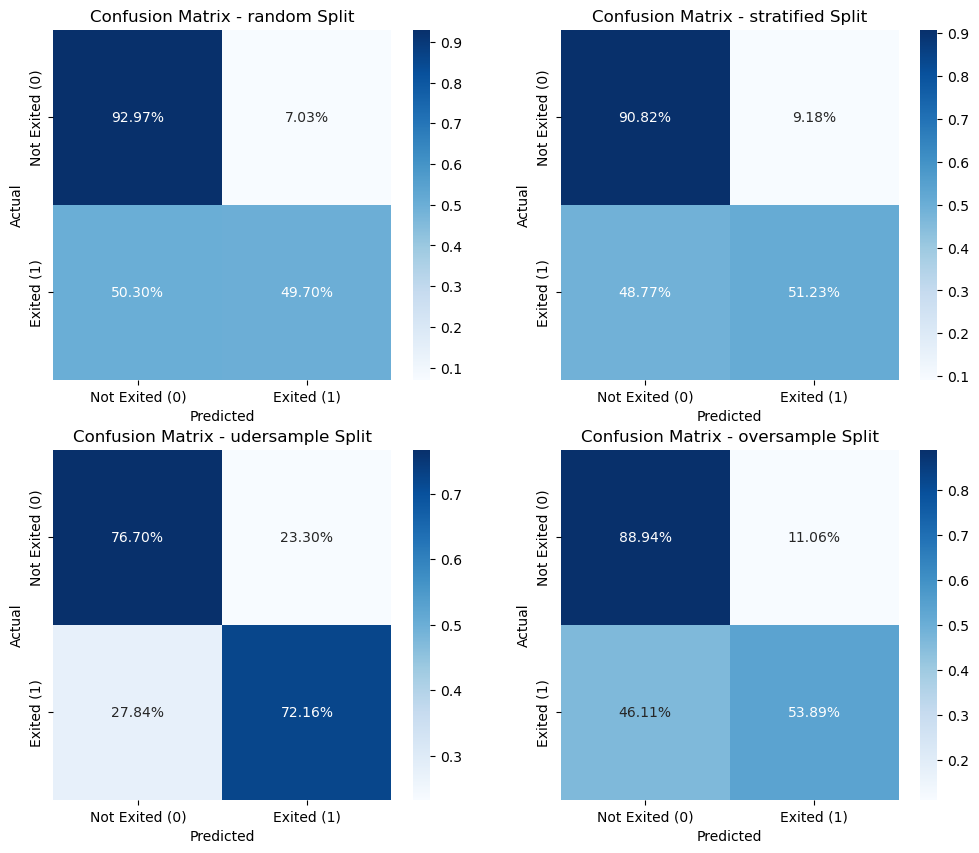

<Figure size 800x600 with 0 Axes>

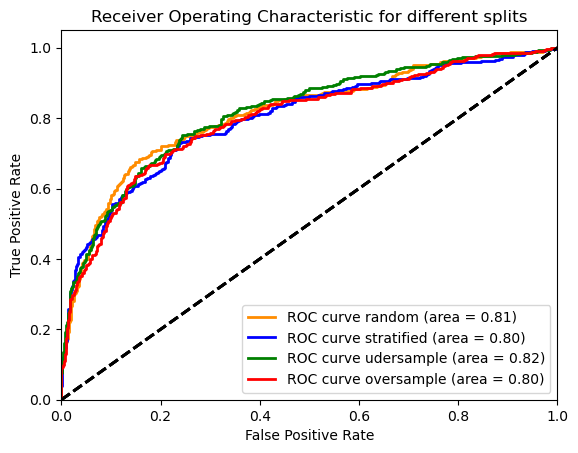

In [32]:
# Create a new model with the best parameters from the randomized search
best_model_RS = MLPClassifier(**best_params_random, max_iter=1000, random_state=42)
performance_RS = {}
performance_RS = evaluating_perfromance_diff_splits(model=best_model_RS,split_data=split_data,performance_matrix=performance_RS)

In [33]:
performance_RS_df = pd.DataFrame(performance_RS).T
performance_RS_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.650980,0.497006,0.563667,334.0,0.813818,0.713353
stratified,0.588028,0.512270,0.547541,326.0,0.800178,0.710217
udersample,0.449627,0.721557,0.554023,334.0,0.816959,0.744270
oversample,0.562500,0.538922,0.550459,334.0,0.799720,0.714169


Again getting worse after trying to fine-tune I might try run this in Google Colab to see if I see any improved performance, then import the new parameters from there into here.

### Bagging

We will do some bagging using our original model as hyper-parameter tuning hasn't been giving much success. Bagging will hopefully be a good choice as an ensemble method as our dataset is imbalanced and this could be a method to help improve performance despite this.

It has been used in medical scenaries to help improve performance where imbalanced data is common. 

I. Fakhruzi, "An artificial neural network with bagging to address imbalance datasets on clinical prediction," 2018 International Conference on Information and Communications Technology (ICOIACT), Yogyakarta, Indonesia, 2018, pp. 895-898, doi: 10.1109/ICOIACT.2018.8350824. keywords: {Bagging;Biological neural networks;Artificial neural networks;Classification algorithms;Data mining;Prediction algorithms;class imbalance problem;bagging;neural networks},



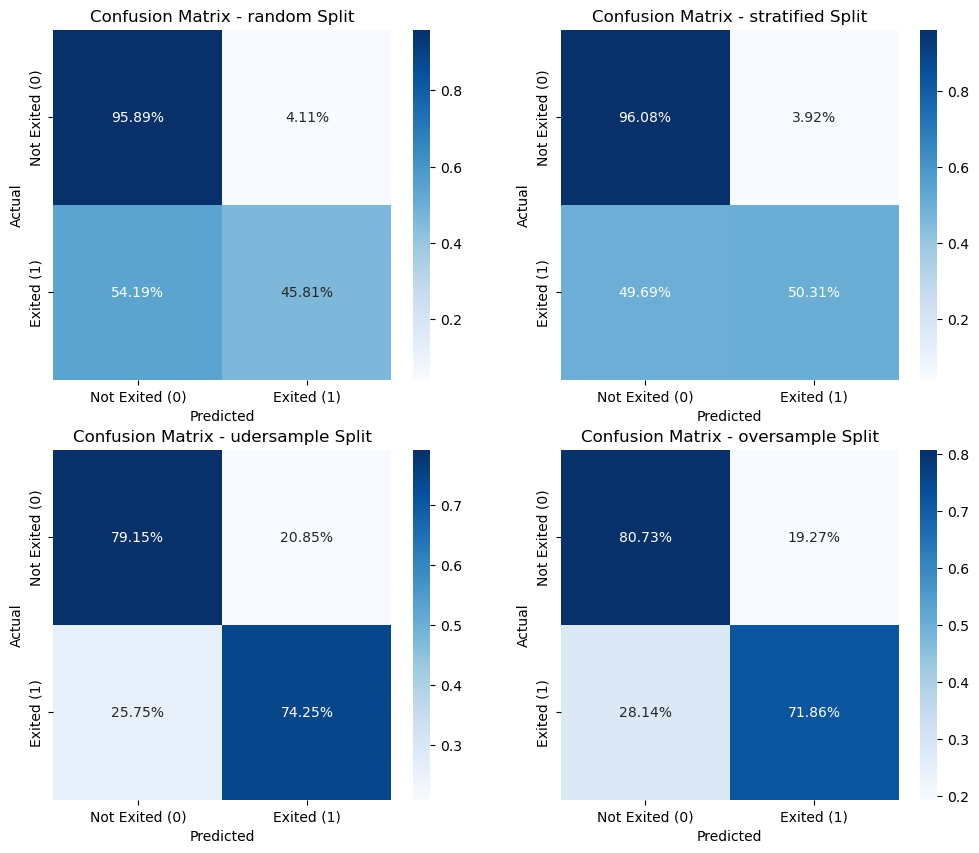

<Figure size 800x600 with 0 Axes>

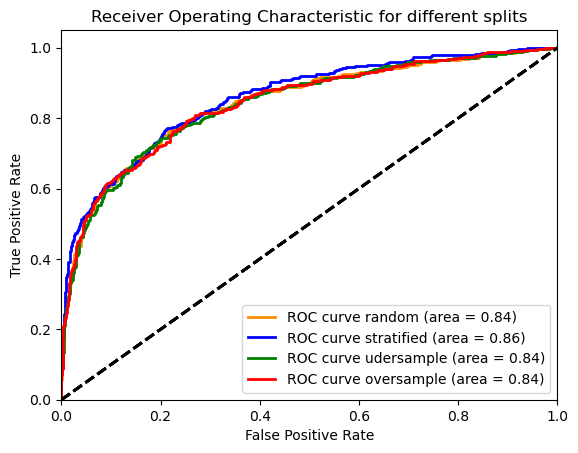

{'random': {'precision': 0.7463414634146341,
  'recall': 0.45808383233532934,
  'f1-score': 0.5677179962894249,
  'support': 334.0,
  'roc_auc': 0.8438549441401556,
  'balanced_accuracy': 0.708504791365137},
 'stratified': {'precision': 0.7663551401869159,
  'recall': 0.5030674846625767,
  'f1-score': 0.6074074074074074,
  'support': 326.0,
  'roc_auc': 0.8567142760832507,
  'balanced_accuracy': 0.7319105084223401},
 'udersample': {'precision': 0.484375,
  'recall': 0.7425149700598802,
  'f1-score': 0.5862884160756501,
  'support': 334.0,
  'roc_auc': 0.8408183632734532,
  'balanced_accuracy': 0.7669920821863382},
 'oversample': {'precision': 0.49586776859504134,
  'recall': 0.718562874251497,
  'f1-score': 0.58679706601467,
  'support': 334.0,
  'roc_auc': 0.8431407327525042,
  'balanced_accuracy': 0.762914928436965}}

In [38]:
from sklearn.ensemble import BaggingClassifier

# Define the model
model = MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Define the bagging classifier
bagging_model = BaggingClassifier(estimator=model, n_estimators=20, random_state=42)
performance_bagging = {}
evaluating_perfromance_diff_splits(model=bagging_model,split_data=split_data,performance_matrix=performance_bagging)